# Tests for the model following Luo and Rudy
Tim Tyree<br>
start - 1.7.2021,
end - 1.8.2021?

In [1]:
#TODO: use lookup table instead of using comp_ionic_currents
from lib.my_initialization import *
from lib.model.LR_model import *
%autocall 1
%load_ext autoreload
%autoreload 2

Automatic calling is: Smart


In [2]:
#TODO(later): plot the Multivariable currents somehow.  Consider 2-3 values of each gating variable chosen at max/half/min voltage
#Multivariable currents
# #Fast sodium current
# INa = GNa*m**3*h*j*(V-ENa)

# Isi=Gsi*d*f*(V-Esi)

# #TODO: determine the range of valid calcium concentrations
# #choose an arbitrary calcium concentration
# Ca_i=0.0002 #mM

# #Slow inward current
# Esi=7.7-13.0287*np.log(Ca_i)#mV
# Isi=Gsi*d*f*(V-Esi)

# define functions for input/output

In [3]:
def load_buffer_LR(input_file_name, Ca_i_initial = 2*10**-4, Vmax = 35., Vmin = -85.):
    '''
    load_buffer_LR maps the 3 channel/variable initial conditions in txt_ic
    to a not-unreasonable  8 channel/variable buffer initial condition as inVmhjdfx
    and linearly rescales voltage by Vscale and shifts by Vshift.
    
    Ca_i_initial is a float in calcium concentration units of mM.
    input_file_name is a string listing the path to one .npz file with the first entry as a width by height by 3 channel numpy array.
    Example Usage:
    inVmhjdfx = load_buffer_LR(input_file_name)
    
    By default, maps a dimensionless, normalized voltage Vmin from 0 to -84mV and Vmax from 1 to 35mV.
    '''
    txt_ic = load_buffer(input_file_name)
        
    Vscale = Vmax-Vmin
    Vshift = Vmin
    
    Vfield = Vscale*txt_ic[...,0]+Vshift
    ffield = txt_ic[...,1]
    sfield = txt_ic[...,2]

    mfield = ffield.copy()
    hfield = ffield.copy()
    jfield = ffield.copy()
    dfield = sfield.copy()
    ffield = sfield.copy()
    xfield = ffield.copy()
    inCa_i = Ca_i_initial + 0.*ffield.copy()

    inVmhjdfxc = np.array([
        Vfield,
        mfield, 
        hfield,
        jfield,
        dfield,
        ffield,
        xfield,
        inCa_i
    ],dtype=np.double).T
    return inVmhjdfxc

def get_voltage_field_scaled_and_shifted(txt, Vmin_new=0., Vmax_new=1., Vmin_old=-85., Vmax_old=35.):
    '''get_voltage_field_scaled_and_shifted returns the transmembrane voltage field with values scaled/shifted to Vmin_new and Vmax_new.
    txt is a numpy array with transmembrane voltage field in the first channel, and may contain other fields in later channels.
    '''
    Vfield = txt[...,0]
    Vmin_old = np.min(Vfield)
    Vscale = (Vmax_new-Vmin_new)/(Vmax_old-Vmin_old)
    Vshift = Vmax_new/Vscale-Vmax_old
    Vfield_new = Vscale*(Vfield+Vshift)
    return Vfield_new

# Simple local tests for given pixel

In [4]:
#test scaling from mV to dimensionless voltage for plotting
input_file_name=f"{nb_dir}/Data/test_data/test_txt.npz"
txt=load_buffer_LR(input_file_name, Ca_i_initial = 2*10**-4, Vmax = 35., Vmin = -85.)
txt_plt = get_voltage_field_scaled_and_shifted(txt, Vmin_new=0., Vmax_new=1., Vmin_old=-85., Vmax_old=35.)
assert np.isclose(np.max(txt_plt),1.,atol=1e-1)
assert np.isclose(np.min(txt_plt),0.,atol=1e-10)

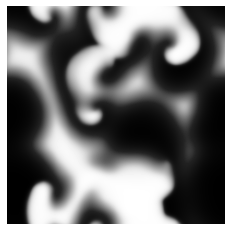

In [5]:
plt.imshow(txt_plt, cmap='gray')
plt.axis('off')
plt.show()

In [6]:
# input_file_name=search_for_file()
# print ( input_file_name )
input_file_name=f"{nb_dir}/Data/test_data/test_txt.npz"
inVmhjdfxc = load_buffer_LR(input_file_name)
txt=inVmhjdfxc
zero_txt = np.zeros_like(txt)
width,height,chnlno = txt.shape
print (f"buffer dimensions are width, height, chnlno = { width,height,chnlno }.") 
comp_ionic_currents = get_comp_ionic_currents(K_i=145.0,K_o=5.4,ENa=54.4,EK=-77.0,method='njit')

comp_rate_of_change_at_pixel_LR=get_comp_rate_of_change_at_pixel_LR(ds = 0.015, width =200, height=200, 
Cm=1., diffCoef=0.001,	Na_i = 18, Na_o = 140, K_i  = 145, K_o  = 5.4, Ca_o = 1.8,
method='njit')

buffer dimensions are width, height, chnlno = (200, 200, 8).


In [8]:
#local tests
x=5;y=7
C = pbc(inVmhjdfxc, x, y)
assert C.shape[0]==8
V = C[0] #mV transmembrane voltage 
#gating variables
m = C[1] #activation gate parameter (Na)
h = C[2] #fast inactivation gate parameter (INa)
j = C[3] #slow inactivation gate parameter (INa)
d = C[4] #activation gate parameter (Isi)
f = C[5] #inactivation gate parameter (Isi)
x_var = C[6] #activation gate parameter (IK)
Ca_i = C[7] # calcium concentration inside the cell 
#test comp_ionic_currents
Iion, dCa_i_dt = comp_ionic_currents(V, m, h, j, d, f, x_var, Ca_i)
assert Iion
assert dCa_i_dt

cddx=1.;cddy=1.#not actual values
#test laplacian
dVltdt=laplacian(inVmhjdfxc, x, y, cddx, cddy, V)	
assert dVltdt 

#test comp_rate_of_change_at_pixel_LR
retval = comp_rate_of_change_at_pixel_LR(txt, x, y)
assert retval.shape[0]==8

In [9]:
#percent of nan values in Vfield
Vfield=txt[...,0]
print(f"percent of nan values in Vfield is {100*Vfield[np.isnan(Vfield)].size/Vfield.size}%.")

percent of nan values in Vfield is 0.0%.


# TODO: test forward euler integration

In [10]:
def get_compute_dtxtdt(ds = 0.015, width =200, height=200, Cm=1., diffCoef=0.001,
                       Na_i = 18, Na_o = 140, K_i  = 145, K_o  = 5.4, Ca_o = 1.8,method='njit'):
    if method=='njit':
        njitsu = njit
    if method=='cuda':
        import numba.cuda.njit as njitsu
    comp_rate_of_change_at_pixel_LR=get_comp_rate_of_change_at_pixel_LR(ds = ds, width = width, height = height, Cm=Cm, diffCoef=diffCoef,
                                                                        Na_i = Na_i, Na_o = Na_o, K_i  = K_i, K_o  = K_o, Ca_o = Ca_o,method='njit')
#     @njitsu
    def compute_dtxtdt(txt,out):
        for x in range(width):
            for y in range(height):
                out[x,y] = comp_rate_of_change_at_pixel_LR(inVmhjdfxc, x, y)
    return compute_dtxtdt

In [11]:
compute_dtxtdt=get_compute_dtxtdt(ds = 0.015, width =200, height=200, Cm=1., diffCoef=0.001,
                       Na_i = 18, Na_o = 140, K_i  = 145, K_o  = 5.4, Ca_o = 1.8,method='njit')

In [12]:
#global tests for discrete flow map
dtxt_dt=zero_txt.copy()
compute_dtxtdt(txt,out=dtxt_dt)
assert (dtxt_dt.shape==txt.shape)
assert not np.isnan(txt).any()
assert not np.isnan(dtxt_dt).any()

In [20]:
def get_one_step_forward_euler(txt,method='njit'):
    if method=='njit':
        njitsu = njit
    if method=='cuda':
        import numba.cuda.njit as njitsu
    zero_txt = np.zeros_like(txt)

#     @njitsu
    def one_step_forward_euler(txt,dt):
        dtxt_dt=zero_txt.copy()
        compute_dtxtdt(txt,out=dtxt_dt)
        txt += dt*dtxt_dt
    
    return one_step_forward_euler

In [21]:
one_step_forward_euler=get_one_step_forward_euler(txt)

In [22]:
#TODO: visualize txt after integrating by one_time_step_forward_euler a few times
#TODO(later, after validating): comp_next_time_step(dt_prev, dV)
def multi_step_forward_euler(txt,numsteps=4,dt = 0.01):
    for stepnum in range(numsteps):
        one_time_step_forward_euler(txt, dt)
    return txt

# TODO: Visualize I vs. V curves and verify they agree with Qu2000 or Luo1990

In [23]:
#TODO: compute Iion_values
#TODO: plot IV curves of the LR model.
#TODO: plot Iion versus various arguments
#TODO: use IV curves of the LR model to make a lookup table
#TODO: for lookup table, make an N-linear interpolation function.  Can N=1? or N=2 or 8?
#TODO: measure the speedup between using simple implementation versus using a lookup table
chnlno=8#Iion_values.shape[-1]
argument_grid=None

In [24]:
input_file_name=f"{nb_dir}/Data/test_data/test_txt.npz"
inVmhjdfxc = load_buffer_LR(input_file_name)
txt = inVmhjdfxc
comp_ionic_currents = get_comp_ionic_currents(K_i=145.0,K_o=5.4,ENa=54.4,EK=-77.0,method='njit')

In [25]:
##################################################
# Read Channels from Buffer
##################################################
x=1;y=2
C = pbc(inVmhjdfxc, x, y)
V = C[0] #mV transmembrane voltage 
#gating variables
m = C[1] #activation gate parameter (Na)
h = C[2] #fast inactivation gate parameter (INa)
j = C[3] #slow inactivation gate parameter (INa)
d = C[4] #activation gate parameter (Isi)
f = C[5] #inactivation gate parameter (Isi)
x_var = C[6] #activation gate parameter (IK)
Ca_i = C[7] # calcium concentration inside the cell 
# Ca_i = pbc(inCa_i, x, y)[0]
Iion, dCa_i_dt = comp_ionic_currents(V, m, h, j, d, f, x_var, Ca_i)

In [26]:
Iion

-278.64225538439274

In [27]:
dCa_i_dt

0.0008918983525264588

In [28]:
(V, m, h, j, d, f, x_var, Ca_i)

(-82.91926103056498,
 0.6303650128186965,
 0.6303650128186965,
 0.6303650128186965,
 0.9260237534031684,
 0.9260237534031684,
 0.9260237534031684,
 0.0002)

# TODO: plot comp_gating_constants versus V
- TODO: plot Iion versus various arguments
- TODO: estimate which ranges should be precomputed
- TODO: define lookup_Iion function that uses linear interpolation of nearest Iion_values.  Note that 
- TODO: generate lookup table for Luo-Rudy Model


In [30]:
#TODO: plot comp_gating_constants versus V
#TODO: plot get_comp_ionic_currents(K_i=145.0,K_o=5.4,ENa=54.4,EK=-77.0,method='njit',**kwargs)
#TODO: check that result of comp_rate_of_change_at_pixel_LR yields timesteps correctly/reasonably.  if not, maybe x and y are flipped.

V = 0.
comp_gating_constants=get_comp_gating_constants()
retval=comp_gating_constants(V)
retval

array([6.53670552e-02, 4.97581411e-02, 3.46920735e+00, 2.25490529e+01,
       2.70258263e+02, 4.98880372e+02, 9.94770636e-01, 0.00000000e+00,
       0.00000000e+00, 9.25477210e-01, 3.82981053e-02, 8.65221872e-01])

In [31]:
#test comp_gating_constants
retval=comp_gating_constants(V)
tau_m, tau_h, tau_j, tau_d, tau_f, tau_x, m_infty, h_infty, j_infty, d_infty, f_infty, x_infty=retval
assert retval.shape[0]==12

In [32]:
tau_m, tau_h, tau_j, tau_d, tau_f, tau_x 
# m_infty, h_infty, j_infty, d_infty, f_infty, x_infty

(0.06536705522350429,
 0.049758141083938695,
 3.4692073465945543,
 22.549052885989774,
 270.25826263664544,
 498.8803721605909)

In [33]:
#compute the gating variables versus voltage
Vmin=-85.
Vmax=35.
num_values=50
V_values = np.linspace(Vmin,Vmax,num_values)
x_values = V_values
retval_lst = []
for V in V_values:
    retval=comp_gating_constants(V)
    retval_lst.append(retval)
retval_values=np.array(retval_lst)
#rate constants
tau_m_values=retval_values[:,0]
tau_h_values=retval_values[:,1]
tau_j_values=retval_values[:,2]
tau_d_values=retval_values[:,3]
tau_f_values=retval_values[:,4]
tau_x_values=retval_values[:,5]
#equilibrium constants
m_infty_values=retval_values[:,6]
h_infty_values=retval_values[:,7]
j_infty_values=retval_values[:,8]
d_infty_values=retval_values[:,9]
f_infty_values=retval_values[:,10]
x_infty_values=retval_values[:,11]

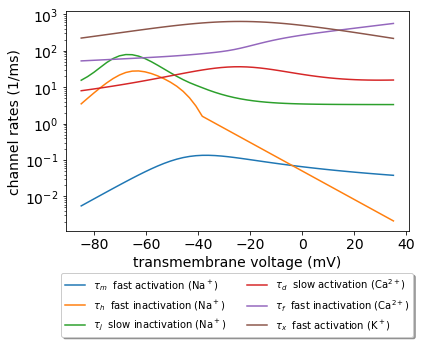

In [34]:
#plot channel rates versus V
fontsize=14
save=True
plt.subplots(figsize=(6,5))
plt.plot(x_values,tau_m_values, label=r'$\tau_m$  fast activation (Na$^+$)')
plt.plot(x_values,tau_h_values, label=r'$\tau_h$  fast inactivation (Na$^+$)')
plt.plot(x_values,tau_j_values, label=r'$\tau_j$  slow inactivation (Na$^+$)')
plt.plot(x_values,tau_d_values, label=r'$\tau_d$  slow activation (Ca$^{2+}$)')
plt.plot(x_values,tau_f_values, label=r'$\tau_f$  fast inactivation (Ca$^{2+}$)')
plt.plot(x_values,tau_x_values, label=r'$\tau_x$  fast activation (K$^+$)')
plt.legend(ncol=2, fontsize=fontsize-4,loc='upper center',bbox_to_anchor=(0.5, -0.17),fancybox=True, shadow=True)
plt.yscale('log')
plt.tick_params(labelsize=fontsize)
plt.xlabel('transmembrane voltage (mV)', fontsize=fontsize)
plt.ylabel('channel rates (1/ms)', fontsize=fontsize)
if not save:
    plt.show()
else:
    os.chdir(os.path.join(nb_dir,'Figures/methods'))
    savefig_fn='LR_model_rates.png'
    plt.tight_layout()
    plt.savefig(savefig_fn,dpi=300)

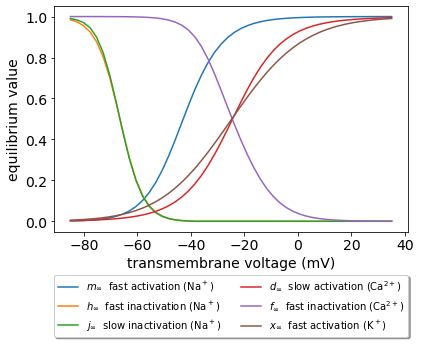

In [35]:
#plot equilibrium values versus V
fontsize=14
save=True
plt.subplots(figsize=(6,5))
plt.plot(x_values,m_infty_values, label=r'$m_\infty$  fast activation (Na$^+$)')
plt.plot(x_values,h_infty_values, label=r'$h_\infty$  fast inactivation (Na$^+$)')
plt.plot(x_values,j_infty_values, label=r'$j_\infty$  slow inactivation (Na$^+$)')
plt.plot(x_values,d_infty_values, label=r'$d_\infty$  slow activation (Ca$^{2+}$)')
plt.plot(x_values,f_infty_values, label=r'$f_\infty$  fast inactivation (Ca$^{2+}$)')
plt.plot(x_values,x_infty_values, label=r'$x_\infty$  fast activation (K$^+$)')
plt.legend(ncol=2, fontsize=fontsize-4,loc='upper center',bbox_to_anchor=(0.5, -0.17),fancybox=True, shadow=True)
# plt.yscale('log')
plt.tick_params(labelsize=fontsize)
plt.xlabel('transmembrane voltage (mV)', fontsize=fontsize)
plt.ylabel('equilibrium value', fontsize=fontsize)
if not save:
    plt.show()
else:
    os.chdir(os.path.join(nb_dir,'Figures/methods'))
    savefig_fn='LR_model_equilibrium_values.png'
    plt.tight_layout()
    plt.savefig(savefig_fn,dpi=300)

In [36]:
#DONE: check x is copied correctly
#DONE: check f is copied correctly


#TODO: implement a linear wave for making plots in methods
#TODO: determine which gates are on/off for a linear action potential
#TODO: plot I versus V for various gates on/off

# TODO: retry timestepping with (i) smaller time step or (ii) finer spatial discretization


# Visualize int(er?)cellular calcium dynamics


In [37]:
#TODO: determine the range of valid calcium concentrations
#Hint: calcium uptake rate (dominated by activity of the sarcoplasmic reticulum)
# 		dCa_i_dt=-10**-4*Isi+0.07*(10**-4-Ca_i)

# TODO: Plot each 1 variable current source

_to Methods on the introduction of \section_{ __Electrophysiological model following Luo and Rudy__ }

The fast potassium current, $I_{K_f}$ has previously been referred to as the time-dependent potassium current and the slow potassium current, $I_{K_s}$has previously been referred to as the plateau potassium current CITE Luo1990.pdf.

The change has been made to name the dynamical variable $w\in[0,1]$ instead of $x$ to avoid confusion with the spatial coordinate, $x$.

In [38]:
#maximum conductances
GNa = 16.     #mS/cm^2 from Qu2000.pdf #GNa=23 in Luo1990.pdf
GK1 = 0.6047  #mS/cm^2 from Qu2000.pdf
Gsi = 0.052   #mS/cm^2 spiral wave breakup phase from Qu2000.pdf
GK  = 0.423   #mS/cm^2 #from Qu2000.pdf

#reversal potentials
EK1 = -87.94
EKp = EK1
Eb = -59.87 #mV
EK=-77.0

In [39]:
#compute Single variable currents versus voltage
IKp_lst=[]; Ib_lst=[]; IK1_lst=[]
for V in V_values:
    #Slow potassium current
    Kp=1.0/(1.0+np.exp((7.488-V)/5.98))
    IKp=0.0183*Kp*(V-EKp)

    #Fast potassium parameters
    aK1=1.02/(1.0+np.exp(0.2385*(V-EK1-59.215)))
    bK1=(0.49124*np.exp(0.08032*(V-EK1-5.476)))+np.exp(0.06175*(V-EK1-594.31))/(1.0+np.exp(-0.5143*(V-EK1+4.753)))
    K1infty = aK1/(aK1 + bK1)
    #fast potassium current (A)
    IK1=GK1*K1infty*(V-EK1)

    #Background Current
    Ib=0.03921*(V+59.87)
    
    IK1_lst.append(IK1)
    IKp_lst.append(IKp)
    Ib_lst.append(Ib)
IKf_values = np.array(IK1_lst)
IKs_values = np.array(IKp_lst)
Ib_values = np.array(Ib_lst)

In [40]:
#instead of the 3D plots, use x=0,0.5,1 for a standard plt.plot
IKa_lst = [];IKb_lst = [];IKc_lst = [];
xa=0.;xb=0.5;xc=1.0;
for V in V_values:
    #fast potassium current (B)
    if V>-100.0:#mV
        x1=2.837*(np.exp(0.04*(V+77.0))-1.0)/(V+77.0)*np.exp(0.04*(V+35.0))
    else:
        x1=1.0
    IK=GK*xa*x1*(V-EK)
    IKa_lst.append(IK)
    IK=GK*xb*x1*(V-EK)
    IKb_lst.append(IK)
    IK=GK*xc*x1*(V-EK)
    IKc_lst.append(IK)
IKfa_values = np.array(IKa_lst)
IKfb_values = np.array(IKb_lst)
IKfc_values = np.array(IKc_lst)

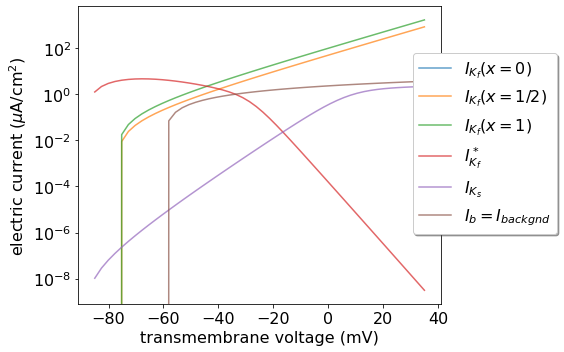

In [41]:
#plot simple currents versus V
fontsize=16
save=True
plt.subplots(figsize=(7.5,5))
plt.plot(x_values,IKfa_values,alpha=0.7,label=r'$I_{K_f}(x=0)$')
plt.plot(x_values,IKfb_values,alpha=0.7,label=r'$I_{K_f}(x=1/2)$')
plt.plot(x_values,IKfc_values,alpha=0.7,label=r'$I_{K_f}(x=1)$')
plt.plot(x_values,IKf_values,alpha=0.7,label=r'${I}^*_{K_f}}$')
plt.plot(x_values,IKs_values,alpha=0.7,label=r'$I_{K_s}$')
plt.plot(x_values,Ib_values,alpha=0.7,label=r'$I_{b}=I_{backgnd}$')
plt.legend(ncol=1, fontsize=fontsize, bbox_to_anchor=(.9,.87), fancybox=True, shadow=True)
plt.yscale('log')
plt.tick_params(labelsize=fontsize)
plt.xlabel(r'transmembrane voltage (mV)', fontsize=fontsize)
plt.tight_layout()
plt.ylabel('electric current ($\mu$A/cm$^2$)', fontsize=fontsize)
if not save:
    plt.show()
else:
    os.chdir(os.path.join(nb_dir,'Figures/methods'))
    savefig_fn='LR_model_simple_currents.png'
    plt.savefig(savefig_fn,dpi=300)

# TODO(later): Plot I/V curves y=0,0.5,1. for y in {m,h,j,d,f}

# TODO: plot the local action potential 
using $\frac{dV}{dt}=-I_{ion}/C_m$ to advance $V(t=0)=V_{activ.}+\delta V$,
- TODO(later): plot range for Ca_i
- TODO(later): plot I/V curve for gate state in each phase of the apparent action potential

In [42]:
#initialize integration
Cm=1. # µF/cm^2 membrane capacitance determined by gap junctions between myocardial cells

#TODO: initialize V, m, h, j, d, f, x_var, Ca_i at the Q wave of the PQRST complex
V, m, h, j, d, f, x_var, Ca_i


(35.0,
 0.6303650128186965,
 0.6303650128186965,
 0.6303650128186965,
 0.9260237534031684,
 0.9260237534031684,
 0.9260237534031684,
 0.0002)

In [43]:
Iion, dCa_i_dt = comp_ionic_currents(V, m, h, j, d, f, x_var, Ca_i)
dVdt=-Iion/Cm